In [1]:
import pandas as pd
print "Pandas Version: ", pd.__version__
%pylab inline

Pandas Version:  0.16.2
Populating the interactive namespace from numpy and matplotlib


### Objetivo:

El Objetivo de este documento es hacer un análisis de los resultados provisorios de las Elecciones PASO Presidenciales en busca de posibles irregularidades en el proceso de conteo y carga de datos.

### Introducción

 - La base de datos fue obtenida a través del Grupo OpenDataCórdoba. Los datos venian en un archivo SQLite.
 - De la base de datos extraje 3 tablas:
  - NomPartidos: Para identificar los Partidos
  - MesasCandidaturasPresidente: Para extraer la cantidad de votos a presidente de cada partido. No está desglozado por candidato, sino por Frente/Alianza.
  - NomAmbitos: Para identificar a través de texto las localidades


### Read and Merge Data

In [12]:
nom_partidos = pd.read_csv('./data/NomPartidos', encoding='iso-8859-1')
mesas_presidente = pd.read_csv('./data/MesasCandidaturaPresidente', encoding='iso-8859-1')
nom_ambitos = pd.read_csv('./data/NomAmbitos', encoding='iso-8859-1')

nom_partidos.replace({'á': 'a','é': 'e','í': 'i','ó': 'o','ú': 'u'}, inplace=True, regex=True)
nom_ambitos.replace({'á': 'a','é': 'e','í': 'i','ó': 'o','ú': 'u'}, inplace=True, regex=True)

m1 = pd.merge(nom_partidos, mesas_presidente, left_on='parCodigo', right_on='vot_parCodigo')
votos_presidente_complete = pd.merge(m1, nom_ambitos, left_on=['vot_proCodigoProvincia','vot_depCodigoDepartamento'], right_on=['depCodigoProvincia', 'depCodigoDepartamento'])
votos_presidente_complete = pd.DataFrame(votos_presidente_complete)

columns = ['vot_proCodigoProvincia','depNombre', 'vot_munCodigoMunicipio', 'vot_mesCodigoCircuito', 'vot_mesCodigoMesa','parSiglas', 'vot_parCodigo', 'votVotosPartido']
votos_presidente = votos_presidente_complete[columns]
votos_presidente.columns = ['codigo_provincia','nombre_departamento', 'codigo_municipio', 'codigo_circuito', 'codigo_mesa','alianza', 'codigo_partido', 'votos']

### Busqueda de mesas con posibles errores.

##### Top N Mesas con mayor cantidad de votos

El primer criterio es buscar y checkear las mesas donde más votos se obtuvieron por partido. Sospecho que en donde más votos se sacaron, más posibilidades de sumar votos inexistentes había. Una vez identificadas, contrasté una por una en la página web www.resultados.gob.ar. Llegué a analizar las primeras 35 mesas, puede que hallan más.

In [13]:
cantidad_mesas = 35
top = votos_presidente.loc[votos_presidente.votos.order(ascending=False).head(cantidad_mesas).index]

Resultados después de checkear a mano:
 - La mayoría de estas mesas presentan errores entre lo expresado en el Telegrama y lo Expresado en el sistema.
  - Hay errores de Data Entry, se confundían los 0 con 6. (Cabe recalcar que la escritura no era muy prolija aunque en la lógica general se entendía que ese número era imposible)
    - Ejemplo: 
  - Hay errores donde el Total de Votos no coincide con los Registrados en la planilla.
    - Ejemplo: Buenos Aires - Moron - 0669 - 364
  - Hay datos que no presetan incoherencia entre lo ingresado en el sitema y el telegrama enviado. No obstante, la cantidad de votos alta puede indicar que los datos pueden ser erroneos. Iguamente no tengo suficiente información para afirmar fraude y/o error.
    - Ejemplo: 
 - En la Mayoria de las mesas donde la alianza UNA sacó muchos votos, la cantidad de votos asignada es en realidad (según el telegrama) la cantidad total de votos de la mesa. En Muchos casos, el telegrama no presenta nada escrito en los casilleros y sin embargo, en el sistema, se registró el total de votos de la Mesa, a dicho candidato (Ver Ejemplo 2, Ejemplo 3 y Ejemplo 4).
  - Ejemplo: Buenos Aires - Moreno- 663D - 00671
  - Ejemplo 2: Buenos Aires - Zarate - 1013 - 26
  - Ejemplo 3: Buenos Aires - La Plata - 0497 - 583
  - Ejemplo 4: Buenos Aires - La Matanza - 631D - 1251

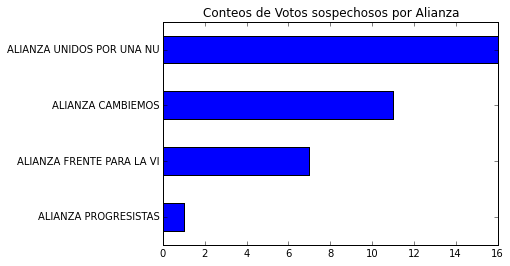

In [14]:
top.alianza.value_counts().order().plot(kind='barh', title="Conteos de Votos sospechosos por Alianza")

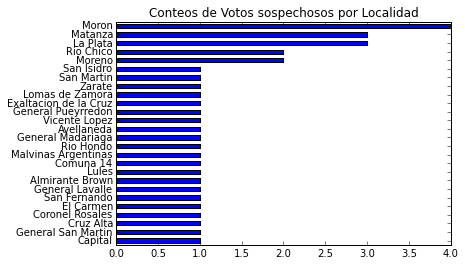

In [15]:
top.nombre_departamento.value_counts().order().plot(kind='barh', title="Conteos de Votos sospechosos por Localidad")

In [17]:
top.drop(['codigo_partido', 'codigo_municipio'], axis=1)

,codigo_provincia,nombre_departamento,codigo_circuito,codigo_mesa,alianza,votos
176302,2,General Madariaga,0340,18,ALIANZA PROGRESISTAS,805
231994,2,Matanza,0635E,2720,ALIANZA FRENTE PARA LA VI,793
394175,2,San Isidro,0892,398,ALIANZA CAMBIEMOS,757
188595,2,General Pueyrredon,0364,112,ALIANZA CAMBIEMOS,682
339617,2,Moron,0673,662,ALIANZA CAMBIEMOS,678
207739,2,General San Martin,0388,913,ALIANZA UNIDOS POR UNA NU,660
281272,2,La Plata,0496,391,ALIANZA UNIDOS POR UNA NU,657
91411,2,Almirante Brown,0021A,888,ALIANZA CAMBIEMOS,645
101578,2,Avellaneda,0030,184,ALIANZA CAMBIEMOS,644
704958,10,El Carmen,0031,821,ALIANZA CAMBIEMOS,386


### Desviaciones de la Media

In [170]:
from scipy.stats.mstats import normaltest

In [176]:
print 'Normal Test'
print 'UNA: teststat = %6.3f and pvalue = %6.4f' % normaltest(votos_presidente[votos_presidente.alianza == "ALIANZA UNIDOS POR UNA NU"].votos)
print 'FPV: teststat = %6.3f and pvalue = %6.4f' % normaltest(votos_presidente[votos_presidente.alianza == "ALIANZA FRENTE PARA LA VI"].votos)
print 'PRO: teststat = %6.3f and pvalue = %6.4f' % normaltest(votos_presidente[votos_presidente.alianza == "ALIANZA CAMBIEMOS        "].votos)

Normal Test
UNA: teststat = 32383.502 and pvalue = 0.0000
FPV: teststat = 2266.021 and pvalue = 0.0000
PRO: teststat = 14191.301 and pvalue = 0.0000


El siguiente análisis se basa en:
 - Calcular Por Provincia, Municipio, y Circuito, el promedio y desviación estándar de cada Alianza
 - Identificar luego, aquellos circuitos con mesas donde la cantidad de votos para el partido difiere en mas de 4 Desviaciones Estandar de la media. (Estadísticamente poco probable)

In [125]:
# Los partidos chicos dan muchos falsos positivos
votos_principales_alianzas = votos_presidente[votos_presidente.alianza.isin(["ALIANZA CAMBIEMOS        ", "ALIANZA FRENTE PARA LA VI", "ALIANZA UNIDOS POR UNA NU"])]

In [126]:
# Estadística Básica de cada Alianza por Circuito.
circuitos = votos_principales_alianzas.groupby(['codigo_provincia','codigo_municipio','codigo_circuito', 'alianza'], as_index=False).votos.describe()
circuitos = circuitos.dropna()

In [154]:
#  los circuitos cuya cantidad de votos supera las
circuitos_dudosos = circuitos[(circuitos['max'] - circuitos['mean']) > (circuitos['std'] * 4)]
circuitos_dudosos = circuitos_dudosos[circuitos_dudosos['max'] < 305] # Ya analizados en el Top N

In [169]:
circuitos_dudosos

count  \
codigo_provincia codigo_municipio codigo_circuito alianza                            
1                1                6               ALIANZA UNIDOS POR UNA NU     46   
                                  11              ALIANZA UNIDOS POR UNA NU     37   
                 2                22              ALIANZA FRENTE PARA LA VI     48   
                                  27              ALIANZA FRENTE PARA LA VI     38   
                                                  ALIANZA UNIDOS POR UNA NU     38   
                 5                58              ALIANZA UNIDOS POR UNA NU     41   
                                  59              ALIANZA UNIDOS POR UNA NU     38   
                                  63              ALIANZA UNIDOS POR UNA NU     59   
                 6                70              ALIANZA FRENTE PARA LA VI     75   
                 7                80              ALIANZA UNIDOS POR UNA NU     38   
                 8                87              ALIANZA UNIDOS POR UNA NU     85   
                                  90              ALIANZA CAMBIEMOS            130   
                 9                94              ALIANZA UNIDOS POR UNA NU     32   
                                  98              ALIANZA UNIDOS POR UNA NU     63   
                 11               117             ALIANZA UNIDOS POR UNA NU     53   
                 12               125             ALIANZA UNIDOS POR UNA NU     61   
                                  127             ALIANZA CAMBIEMOS             68   
                                  132             ALIANZA CAMBIEMOS             59   
                 13               136             ALIANZA UNIDOS POR UNA NU     43   
                 14               0148            ALIANZA FRENTE PARA LA VI     65   
                 15               0161            ALIANZA UNIDOS POR UNA NU     59   
                                  0163            ALIANZA UNIDOS POR UNA NU     36   
                                  0164            ALIANZA CAMBIEMOS             34   
                                  0165            ALIANZA UNIDOS POR UNA NU     57   
                                  0167            ALIANZA UNIDOS POR UNA NU     37   
2                3                0018A           ALIANZA CAMBIEMOS            145   
                                  0019            ALIANZA CAMBIEMOS            255   
                                                  ALIANZA UNIDOS POR UNA NU    255   
                                  0021            ALIANZA CAMBIEMOS            153   
                                  0022            ALIANZA CAMBIEMOS            102   
...                                                                            ...   
21               266              0344            ALIANZA CAMBIEMOS             48   
                                  0349A           ALIANZA UNIDOS POR UNA NU    150   
                                  0353A           ALIANZA UNIDOS POR UNA NU    114   
                                  0358            ALIANZA CAMBIEMOS             42   
                                  0359A           ALIANZA CAMBIEMOS            112   
                 307              0011A           ALIANZA UNIDOS POR UNA NU     28   
                                  0016            ALIANZA CAMBIEMOS            174   
                                  0032            ALIANZA CAMBIEMOS             87   
22               8                0077            ALIANZA CAMBIEMOS             68   
                 10               0044            ALIANZA UNIDOS POR UNA NU     95   
                 11               0048            ALIANZA CAMBIEMOS             77   
                 22               0004A           ALIANZA CAMBIEMOS             37   
                                  0007B           ALIANZA UNIDOS POR UNA NU    100   
                                  0008B           ALIANZA CAMBIEMOS             40   
23               4                0

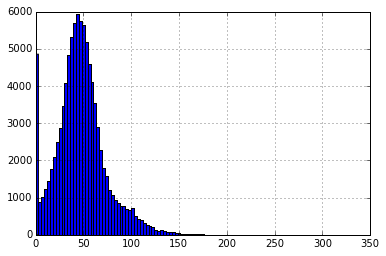

In [159]:
votos_presidente[(votos_presidente.alianza == "ALIANZA UNIDOS POR UNA NU") & (votos_presidente.votos < 305)].votos.hist(bins=100)

##### Cantidad de Mesas con 0 votos registrados

In [21]:
print "Cant Mesas donde el FPV saco 0 votos: ", sum(votos_presidente[votos_presidente.alianza == "ALIANZA FRENTE PARA LA VI"].votos == 0)
print "Cant Mesas donde Cambiemos saco 0 votos: ", sum(votos_presidente[votos_presidente.alianza == "ALIANZA CAMBIEMOS        "].votos == 0)
print "Cant Mesas donde UNA saco 0 votos: ", sum(votos_presidente[votos_presidente.alianza == "ALIANZA UNIDOS POR UNA NU"].votos == 0)

 Cant Mesas donde el FPV saco 0 votos:  3697
Cant Mesas donde Cambiemos saco 0 votos:  3750
Cant Mesas donde UNA saco 0 votos:  4106


##### Listado de mesas donde hay 0 votos para esos partidos

In [22]:
mesas_sin_votos_fpv = votos_presidente[(votos_presidente.alianza == "ALIANZA FRENTE PARA LA VI") & (votos_presidente.votos == 0)]
mesas_sin_votos_cambiemos = votos_presidente[(votos_presidente.alianza == "ALIANZA CAMBIEMOS        ") & (votos_presidente.votos == 0)]
mesas_sin_votos_una = votos_presidente[(votos_presidente.alianza == "ALIANZA UNIDOS POR UNA NU") & (votos_presidente.votos == 0)]

In [23]:
mesas_sin_votos_fpv.head()

,codigo_provincia,nombre_departamento,codigo_municipio,codigo_circuito,codigo_mesa,alianza,codigo_partido,votos
1587,1,Comuna 01,1,1,28,ALIANZA FRENTE PARA LA VI,131,0
1641,1,Comuna 01,1,5,82,ALIANZA FRENTE PARA LA VI,131,0
2052,1,Comuna 01,1,19,493,ALIANZA FRENTE PARA LA VI,131,0
7211,1,Comuna 02,2,25,749,ALIANZA FRENTE PARA LA VI,131,0
11992,1,Comuna 03,3,36,1161,ALIANZA FRENTE PARA LA VI,131,0
